In [1]:
import pandas as pd
import json

In [2]:
# Load Yelp dataset
reviews = []
with open('/kaggle/input/yelp-academic-dataset-review/yelp_academic_dataset_review.json', 'r', encoding='utf-8') as f:
    for line in f:
        reviews.append(json.loads(line))

In [3]:
df = pd.DataFrame(reviews)
df = df[['stars', 'text']].rename(columns={'stars': 'rating', 'text': 'review_text'})

In [4]:
df.head()

,rating,review_text
0,3.0,"If you decide to eat here, just be aware it is..."
1,5.0,I've taken a lot of spin classes over the year...
2,3.0,Family diner. Had the buffet. Eclectic assortm...
3,5.0,"Wow! Yummy, different, delicious. Our favo..."
4,4.0,Cute interior and owner (?) gave us tour of up...


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6990280 entries, 0 to 6990279
Data columns (total 2 columns):
 #   Column       Dtype  
---  ------       -----  
 0   rating       float64
 1   review_text  object 
dtypes: float64(1), object(1)
memory usage: 106.7+ MB


In [6]:
small_df = df.sample(n=100, random_state=42)

In [7]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [8]:
def preprocess(text):
    doc = nlp(text)
    # Remove stopwords/punctuation and lemmatize
    tokens = [token.lemma_.lower() for token in doc
             if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

small_df["cleaned_text"] = small_df["review_text"].apply(preprocess)

In [9]:
small_df.head()

,rating,review_text,cleaned_text
1295256,2.0,Went for lunch and found that my burger was me...,go lunch find burger meh obvious focus burge...
3297618,5.0,I needed a new tires for my wife's car. They h...,need new tire wife car special order day drop ...
1217795,5.0,Jim Woltman who works at Goleta Honda is 5 sta...,jim woltman work goleta honda 5 star knowledge...
3730348,4.0,Been here a few times to get some shrimp. The...,time shrimp get nice selection different fis...
1826590,5.0,This is one fantastic place to eat whether you...,fantastic place eat hungry need good snack g...


In [10]:
from transformers import pipeline

sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english"
)

def analyze_sentiment(text):
    result = sentiment_analyzer(text[:512])[0]  # BERT input limit
    return result["label"], result["score"]

# Apply to dataframe
small_df[["sentiment", "confidence"]] = small_df["cleaned_text"].apply(
    lambda x: pd.Series(analyze_sentiment(x))
)

2025-07-11 11:07:17.372813: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752232037.655771      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752232037.744367      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


In [11]:
small_df.head()

,rating,review_text,cleaned_text,sentiment,confidence
1295256,2.0,Went for lunch and found that my burger was me...,go lunch find burger meh obvious focus burge...,NEGATIVE,0.998444
3297618,5.0,I needed a new tires for my wife's car. They h...,need new tire wife car special order day drop ...,POSITIVE,0.941628
1217795,5.0,Jim Woltman who works at Goleta Honda is 5 sta...,jim woltman work goleta honda 5 star knowledge...,POSITIVE,0.999779
3730348,4.0,Been here a few times to get some shrimp. The...,time shrimp get nice selection different fis...,POSITIVE,0.997428
1826590,5.0,This is one fantastic place to eat whether you...,fantastic place eat hungry need good snack g...,POSITIVE,0.998362


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vectorize text
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(small_df["cleaned_text"])

# Extract topics
lda = LatentDirichletAllocation(n_components=5, random_state=42)
small_df["topic"] = lda.fit_transform(X).argmax(axis=1)

# Map topics to labels
topic_labels = {
    0: "Food Quality",
    1: "Service Experience",
    2: "Pricing",
    3: "Ambiance",
    4: "Wait Time"
}
small_df["topic_label"] = small_df["topic"].map(topic_labels)

In [13]:
small_df.head()

,rating,review_text,cleaned_text,sentiment,confidence,topic,topic_label
1295256,2.0,Went for lunch and found that my burger was me...,go lunch find burger meh obvious focus burge...,NEGATIVE,0.998444,0,Food Quality
3297618,5.0,I needed a new tires for my wife's car. They h...,need new tire wife car special order day drop ...,POSITIVE,0.941628,1,Service Experience
1217795,5.0,Jim Woltman who works at Goleta Honda is 5 sta...,jim woltman work goleta honda 5 star knowledge...,POSITIVE,0.999779,1,Service Experience
3730348,4.0,Been here a few times to get some shrimp. The...,time shrimp get nice selection different fis...,POSITIVE,0.997428,4,Wait Time
1826590,5.0,This is one fantastic place to eat whether you...,fantastic place eat hungry need good snack g...,POSITIVE,0.998362,4,Wait Time


In [14]:
print(f"Overall Positive: {len(small_df[small_df['sentiment']=='POSITIVE'])/len(small_df):.1%}")
print(f"Average Confidence: {small_df['confidence'].mean():.2f}")

# Top complaints
complaints = small_df[small_df['sentiment']=='NEGATIVE']['cleaned_text']
top_complaints = pd.Series(' '.join(complaints).split()).value_counts()[:10]

Overall Positive: 51.0%
Average Confidence: 0.95


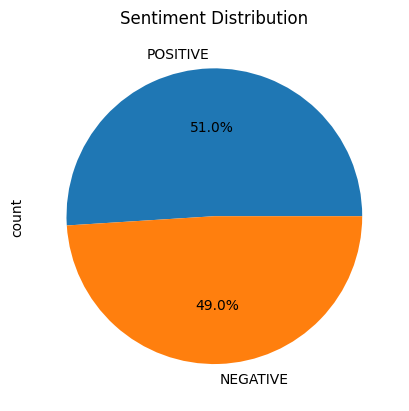

<Axes: xlabel='topic_label'>

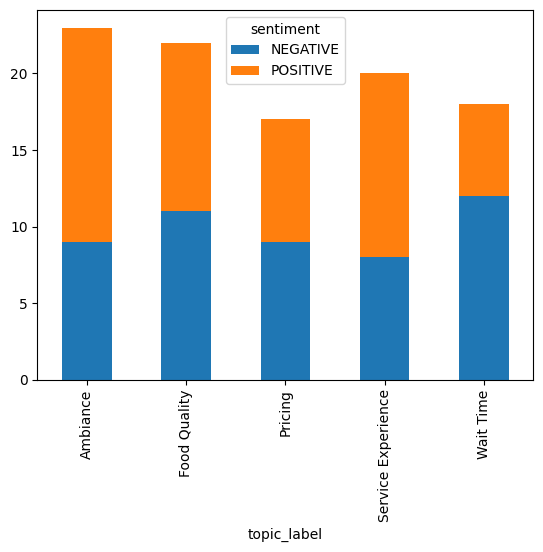

In [15]:
import matplotlib.pyplot as plt

# Sentiment distribution
small_df["sentiment"].value_counts().plot.pie(autopct="%1.1f%%")
plt.title("Sentiment Distribution")
plt.show()

# Topic-sentiment heatmap
pd.crosstab(small_df["topic_label"], small_df["sentiment"]).plot.bar(stacked=True)